# Tutorial 4. Clustering with Unsupervised Learning

In this notebook we will cover the following:

1. [Clustering data using k-means algorithm](#kmeans)
2. [Compressing an image using vector quanization](#quant)
3. [Building a Mean Shift clustering model](#meanshift)
4. [Grouping data using agglomerative clustering](#agglo)
5. [Evaluating the performance of clustering algorithms](#perf)
6. [Automatically estimating the number of clusters using DBSCAN algorithm](#dbscan)
7. [Finding patterns in stock market data](#stock)
8. [Building a customer segmentation model](#customer)

**Unsupervised learning** is an area of machine learning where models are built without relying on labeled training data. This means that learning algorithms cannot categorize data based on labels. Unsupervised learning algorithms are used to find subgroups within datasets using some similarity metric.

The most common method is called **clustering**, where clusters are found using similarity measure like Euclidean distance. Examples of fields where it is used is: data mining, medical imaging, stock market analysis, computer vision, etc.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

##  4.1 Clustering data using k-means algorithm <a class="anchor" id="Kmeans"></a>

K-means is one of the most popular unsupervised clustering algorithms. Divides input data into *k* subgroups using attributes of the data. Grouping is achieved using optimization technique where we minimize the sum of the squares of distances between the datapoints and the corresponding centroid of the cluster. 

In this example we will be using *data_multivar.txt*.

In [2]:
from sklearn import metrics
from sklearn.cluster import KMeans
data = pd.read_csv('data_multivar.txt',names=['x1','x2'])
data.head()

,x1,x2
0,1.96,-0.09
1,2.84,3.16
2,4.74,1.84
3,6.36,4.89
4,1.77,1.55


Plot data by class to see what scatter looks like.

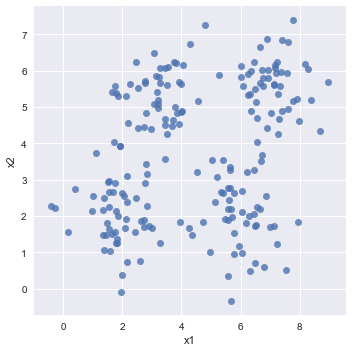

In [3]:
sns.lmplot(data=data,x='x1',y='x2',fit_reg=False)

We can see from the above there seems to be 4 clusters in the data.

### KMeans clustering model

Initialize the k-means object and train it.

In [4]:
n_cluster = 4
#n_init number of times will be run with different centroid seeds
kmeans = KMeans(init='k-means++',n_clusters=n_cluster,n_init=10)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Now visualize the boundaries.

In [5]:
#Step size for mesh grid
def map_boundary_2d(kmeansobj,data):
    step_size = 0.01
    maxs  = data.max()
    mins  = data.min()
    x1,x2 = np.meshgrid(np.arange(mins.x1 -1,maxs.x1+1,step_size), np.arange(mins.x2-1,maxs.x2+1,step_size))
    # Assign labels for al lpoints in mesh
    output = kmeansobj.predict(np.c_[x1.ravel(),x2.ravel()])
    output = output.reshape(x1.shape)
    return x1,x2,output

x1,x2,output = map_boundary_2d(kmeans,data)

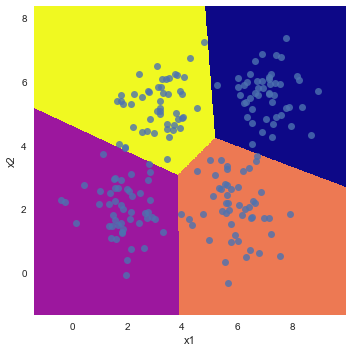

In [6]:
# Plotting
sns.lmplot(data=data,x='x1',y='x2',fit_reg=False)
plt.pcolormesh(x1,x2,output,cmap=plt.cm.plasma,zorder=0)

Now let's plot the centroids from the clustering.

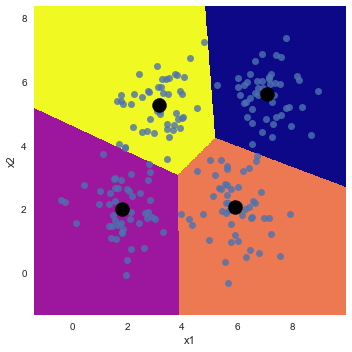

In [7]:
centroids = kmeans.cluster_centers_
sns.lmplot(data=data,x='x1',y='x2',fit_reg=False)
plt.pcolormesh(x1,x2,output,cmap=plt.cm.plasma,zorder=0)
plt.scatter(centroids[:,0],centroids[:,1],marker='o',facecolor='k',s=200)

Can see that the centroids are in the middle of each cluster.

##  4.2 Compressing an image using vector quantization <a class="anchor" id="quant"></a>

One application of k-means clustering is **vector quantization** is the *N*-dimensional version of rounding off. E.g when we have a float number we can represent it as different size bytes which reduces the precision but saves memory. Extend this to *N*-dimensional data, popular in image compression where each pixel we store with fewer bits than the orginal image.

We will show example on *flower_image.jpg*

In [8]:
from sklearn import cluster
from scipy import misc
# Make a function that will take image name and number 
# of bits (number of clusters)

def compress_image(img,nbits):
    nclusters = np.power(2,nbits)
    X = img.reshape((-1,1)) # reshape into array (n_sample,n_feature)
    k_means = cluster.KMeans(n_clusters= nclusters,n_init=4)
    k_means.fit(X)
    values = k_means.cluster_centers_.squeeze()
    labels = k_means.labels_
    #Create an array from labels and values
    #from values array choose the labels: http://stackoverflow.com/questions/24426452/whats-the-difference-between-numpy-take-and-numpy-choose
    compressed = np.choose(labels,values)
    compressed.shape = img.shape
    #Print compression rate
    compression_rate = round(100*(8.0-nbits)/8.0,2)
    return compressed,compression_rate

def plot_compressed_images(img,nbits):
    #Plot together
    fig,axes = plt.subplots(2,2,figsize=[8,8],sharex=True,sharey=True)
    vmin = img.min();vmax=img.max()
    cmap = plt.cm.gray
    #Plot original
    axes[0,0].imshow(img,cmap=cmap,vmin=vmin,vmax=vmax);
    axes[0,0].set_title('Original')
    for bit,ax in zip(bits,axes.ravel()[1:]):
        imgcomp,comprate = compress_image(img,bit)
        ax.imshow(imgcomp,cmap=cmap,vmin=vmin,vmax=vmax)
        ax.set_title('Compressed by {}%'.format(comprate))

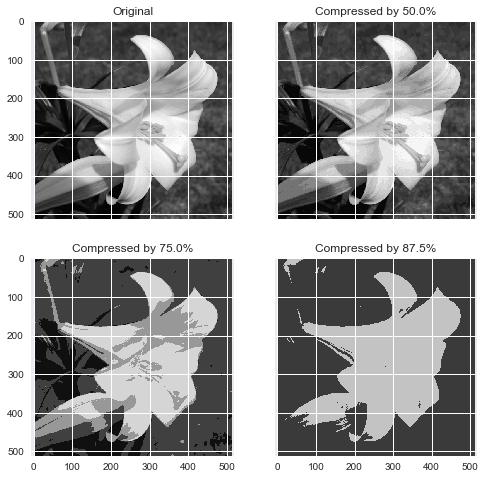

In [9]:
#Load grayscale flower image
flwimg = misc.imread('flower_image.jpg',True).astype(np.uint8) # 8bit integer
bits = [4,2,1]

# Plotting
plot_compressed_images(flwimg,bits)

Can see in the last one with 1 bit that it is just black or white, as only two colors.

Now we'll repeat with scipy's racoon image, and keep full color image (need to divide by 255 so plt.imshow behaves works well, needs to be [0,1].

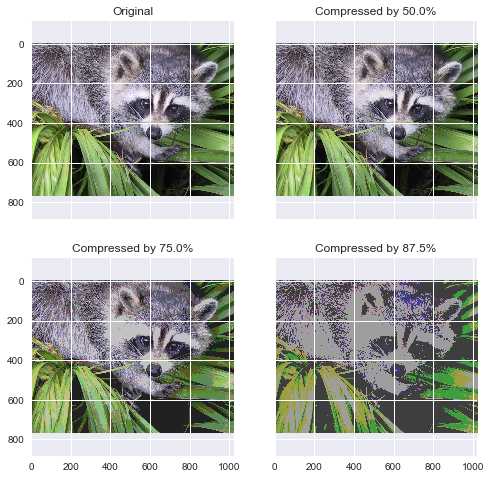

In [10]:
#Racoon image
racoonimg = misc.face()
#Plot
plot_compressed_images(racoonimg/255,bits)

## 4.3 Building a Mean Shift clustering model <a class="anchor" id="meanshift"></a>

The **Mean Shift** is an unsupervised learning algorithm that's used to cluster datapoints. It considers the distribution of datapoints as a probability-density function and tries to find the modes in the feature space. The modes are points corresponding to local maxima. Clusters correspond to peaks in the PDF.

The advantage of **Mean Shift** is that it is not required to know the number of clusters *a-priori*.

Here we'll test out it out on the same previous *data_multivar.txt*.

In [11]:
from sklearn.cluster import MeanShift, estimate_bandwidth

data = pd.read_csv('data_multivar.txt',names=['x1','x2'])
nsamples = len(data.index)

# Estimating the bandwidth
bandwidth = estimate_bandwidth(np.array(data),quantile=0.1,n_samples=nsamples )

# Clustering
meanshift_estimator = MeanShift(bandwidth=bandwidth,bin_seeding=True)

# Train model
meanshift_estimator.fit(data)

MeanShift(bandwidth=1.1467225388006477, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=1, seeds=None)

Extract centroid information:

In [12]:
labels = meanshift_estimator.labels_ #indices of labels
centroids = meanshift_estimator.cluster_centers_
n_clusters = len(np.unique(labels))
print('Number of clusters = ',n_clusters)

Number of clusters =  4


Can see this is what we expected, and now let's visualize the centroids to see how well it performed.

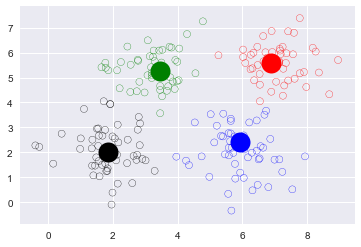

In [13]:
colors = ['k','r','g','b']
#data['labels'] = labels
#display(data.labels)
plt.figure()
for n,c,centroid in zip( range(n_clusters), colors,centroids):
    clusterpoints = data[labels==n]
    plt.scatter(clusterpoints.x1,clusterpoints.x2,facecolors='none',edgecolors=c )
    # Plot centroids on top
    plt.plot(centroid[0],centroid[1],'o',color=c,ms=20)


Can see above that it plots the centroids in the clusters, all with no knowledge on the number of clusters.


## 4.4 Grouping data using agglomerative clustering<a class="anchor" id="agglo"></a>

**Hierarchical clustering** is clustering algorithms that build tree-like clusters by successively splitting or merging them. The hierarchial structure is representing using a tree. This type of algorithm can be either top-down or bottom-up. In bottom-up algorithms, each datapoint is treated as a separate cluster with a single object, they are then successively merged until all the clusters are merged into a single giant cluster. This is called **agglomerative clustering**.

Top-down algorithms start with a giant cluster and succesively split these until indivdiual datapoints are reached.

The advantage of agglomerative clustering is for datapoints that are linked spatially but also located close to each other in space and to extract linked clusters. For this example we will make spiral datapoints.

In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

#Datapoints
def get_spiral(t,noise_amplitude=0.5):
    """ Spiral data"""
    r = t
    x = r*np.cos(t)
    y = r*np.sin(t)
    X = np.concatenate((x,y))
    X += noise_amplitude*np.random.randn(2,X.shape[1])
    return pd.DataFrame(X.T,columns=['x1','x2'])

def get_rose(t,noise_amplitude=0.02):
    """Equation for rose (rhodena curve), if k is odd then curve will have k 
       petals, else will have 2k petals"""
    k=5
    r=np.cos(k*t)+0.25
    x=r*np.cos(t);y=r*np.sin(t)
    X = np.concatenate((x,y))
    X += noise_amplitude*np.random.randn(2,X.shape[1])
    return pd.DataFrame(X.T,columns=['x1','x2'])
    
def get_hypotrochoid(t,noise_amplitude=0):
    a,b,h=10.,2.0,4.0
    x = (a-b)*np.cos(t) - h*np.cos((a-b)/b*t)
    y = (a-b)*np.sin(t) - h*np.sin((a-b)/b*t)
    X = np.concatenate((x,y))
    X += noise_amplitude*np.random.randn(2,X.shape[1])
    return pd.DataFrame(X.T,columns=['x1','x2'])

Generate data from above functions

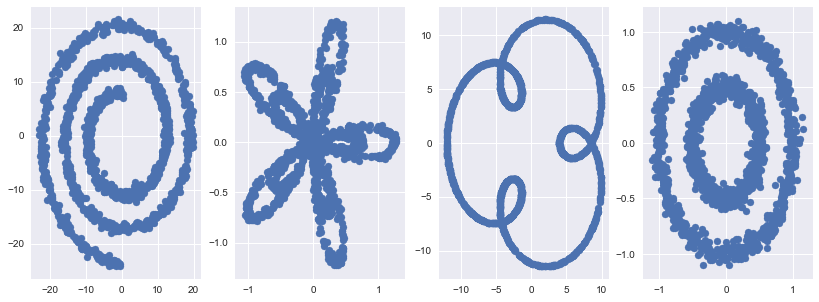

In [15]:
from sklearn import datasets

n_samples = 1500
np.random.seed(2)
t = 2.5*np.pi*(1+2*np.random.rand(1,n_samples))
#Spiral
spiralDF= get_spiral(t)
#Rose
roseDF = get_rose(t)
#Hypotrochoid
hypoDF = get_hypotrochoid(t)
#Circles
X,_ = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
circlesDF =pd.DataFrame(X,columns=['x1','x2']) 

#Make plots
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=[14,5])
ax1.scatter(spiralDF.x1,spiralDF.x2)
ax2.scatter(roseDF.x1,roseDF.x2)
ax3.scatter(hypoDF.x1,hypoDF.x2)
ax4.scatter(circlesDF.x1,circlesDF.x2)

In [16]:
# The linkage criterion determines which distance to use between sets of observation. 
# The algorithm will merge the pairs of cluster that minimize this criterion. For linkages,
# 'ward' minimizes the variance of the clusters being merged, while 'average' uses
# the average of the distances of each observation of the two sets.
def perform_clustering(X, connectivity,num_clusters=2,linkage='average',title='',ax=None):
    # Agglomerative Clustering
    affinity = 'euclidean' if linkage == 'ward' else 'manhattan'
    model = AgglomerativeClustering(linkage=linkage,connectivity=connectivity,
                                    n_clusters=num_clusters,affinity=affinity)
    model.fit(X.values)
    #Extract labels
    labels= model.labels_
    colors = ['k','r','g','b']
    if ax is None:
        f,ax = plt.subplots(1,1)
    for i, col in zip(range(num_clusters),colors):
        #plot points belonging to cluster
        clusterpoints = X[labels==i] 
        ax.scatter(clusterpoints.x1,clusterpoints.x2,facecolors='none',edgecolors=col)
    ax.set_title(title)

Let's show what no-connectivity looks like

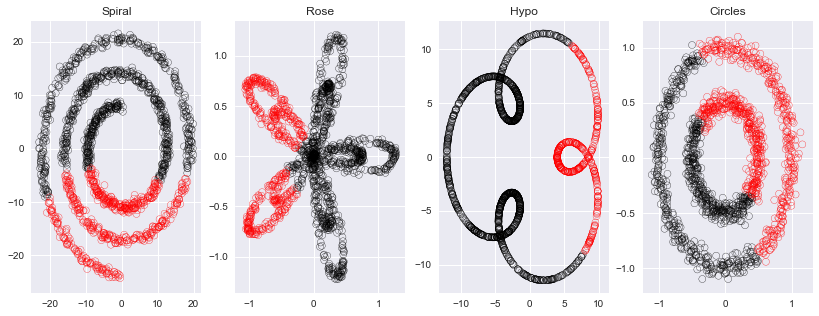

In [17]:
# No connectivity 
connectivity = None
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=[14,5])
perform_clustering(spiralDF,connectivity,title='Spiral',ax=ax1)
perform_clustering(roseDF,connectivity,title='Rose',ax=ax2)
perform_clustering(hypoDF,connectivity,title='Hypo',ax=ax3)
perform_clustering(circlesDF,connectivity,title='Circles',ax=ax4)

Can see above that with no-connectivity, the clusters are all spatially close to eachother.

Now let's try the K-Neighbors

/anaconda/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:418: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


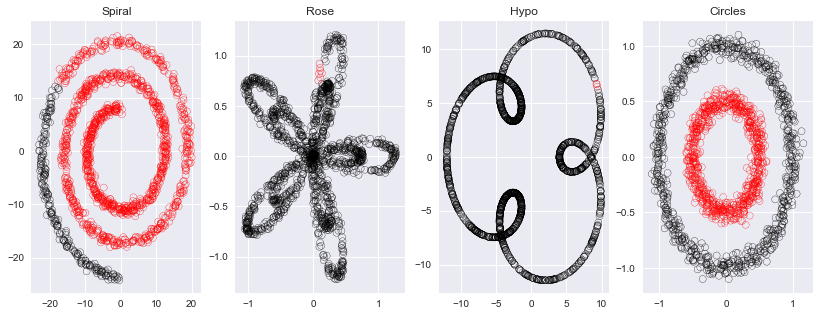

In [18]:
connectivityS=kneighbors_graph(spiralDF.values,10,include_self=False)
connectivityR=kneighbors_graph(roseDF.values,10,include_self=False)
connectivityH=kneighbors_graph(hypoDF.values,10,include_self=False)
connectivityC=kneighbors_graph(circlesDF.values,10,include_self=False)

fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=[14,5])
perform_clustering(spiralDF,connectivityS,title='Spiral',ax=ax1)
perform_clustering(roseDF,connectivityR,title='Rose',ax=ax2)
perform_clustering(hypoDF,connectivityH,title='Hypo',ax=ax3)
perform_clustering(circlesDF,connectivityC,title='Circles',ax=ax4)

We can see from the above that it picks out the inner circle for clustering, if we used the *ward* criterium for linkage it would look different. See below

/anaconda/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


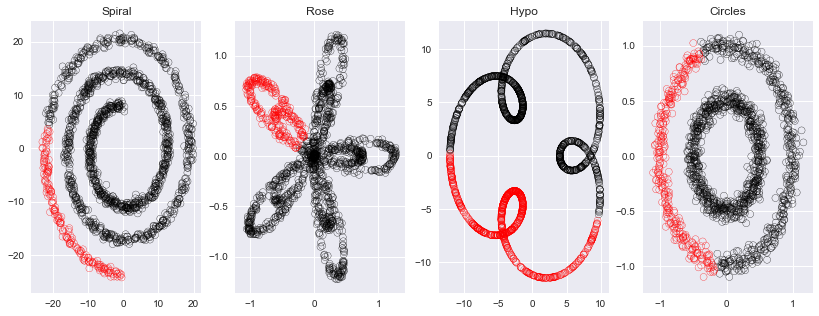

In [19]:
connectivityS=kneighbors_graph(spiralDF.values,10,include_self=False)
connectivityR=kneighbors_graph(roseDF.values,10,include_self=False)
connectivityH=kneighbors_graph(hypoDF.values,10,include_self=False)
connectivityC=kneighbors_graph(circlesDF.values,10,include_self=False)

fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=[14,5])
perform_clustering(spiralDF,connectivityS,title='Spiral',ax=ax1,linkage='ward')
perform_clustering(roseDF,connectivityR,title='Rose',ax=ax2,linkage='ward')
perform_clustering(hypoDF,connectivityH,title='Hypo',ax=ax3,linkage='ward')
perform_clustering(circlesDF,connectivityC,title='Circles',ax=ax4,linkage='ward')

From the above, the classifier was unable to separate the two classes. Resulting in 0% accuracy for class0. Can fix this with adding weighting to classifier, to weight by the number of points.

## 4.5 Evaluating the performance of clustering algorithms<a class="anchor" id="perf"></a>

We need a method to evalute performance of various clustering algorithms, since there are no labels in unsupervised learning, we need a new way. One method would be to measure how well the clusters are separated, and if datapoints in a cluster are tight. Here we will use a metric alled **Silhouette Coefficient** score which is defined for each datapoint as:

*score = (x-y)/max(x,y)*

where *x* is the average distance between the current datapoint and all the other datapoints in the same cluster, and *y* is the average distance between the current datapoint and all the datapoints in the next nearest cluster.

We will work with the data file *data_perf.txt*

In [20]:
from sklearn import metrics
from sklearn.cluster import KMeans
data = pd.read_csv('data_perf.txt',names=['x1','x2'])
data.head()

,x1,x2
0,1.65,1.91
1,2.77,4.98
2,5.82,2.56
3,7.24,5.24
4,-0.30,4.06


Let's plot the data to see what it looks like:

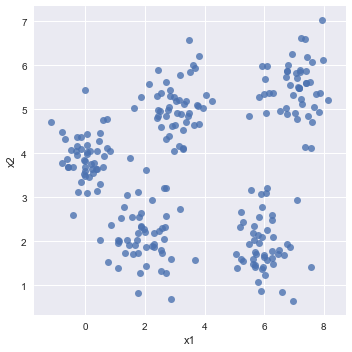

In [21]:
sns.lmplot("x1", "x2", data=data, fit_reg=False)

There appears to be around 5 clusters in the data. We will iterate thourgh a range of values to find the optimal number of clusters.

In [22]:
scores = []
clusters = range(2,10)
for i in clusters:
    # Train the model
    kmeans = KMeans(init='k-means++',n_clusters=i,n_init=10)
    kmeans.fit(data)
    score = metrics.silhouette_score(data,kmeans.labels_,metric='euclidean',
                                    sample_size=len(data.index))
    scores.append(score)
performance= pd.DataFrame({'clusters':clusters,'scores':scores})
performance.head()

,clusters,scores
0,2,0.529040
1,3,0.557247
2,4,0.583276
3,5,0.658280
4,6,0.582358


Can visualize the silhouette scores:

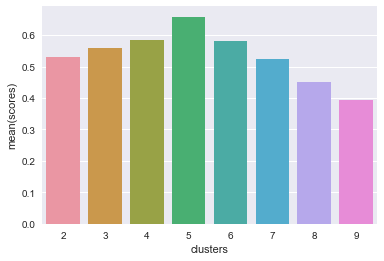

In [23]:
sns.barplot(x='clusters',y='scores',data=performance)

We can see that 5 clusters has the highest score, as we expected when looking at the scattered datapoints. This method can be useful when you are dealing with a huge dataset that contains high-dimensionality that cannot be visualized easily.

## 4.6 Automatically eastimating the number of clusters using DBSCAN algorithm<a class="anchor" id="dbscan"></a>

The K-Means algorithm we saw earlier needs the number of clusters as an input parameter. We could use a sweep of parameter space and evaluate the silhouette scores, but this would be an expensive process.

Similar to the Mean Shift clustering model, the **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)** can retrieve the number of clusters. Works by treating datapoints as groups of dense clusters. If a point belongs to a cluster, then there are a lot of other points that belong to the same cluster around it. One of the parameters that can be controlled is the maximum distance of this point from other points, called **epsilon**. No two points in a cluster should be further away than epsilon.

The main advantage of **DBSCAN** is that it can deal with outliers.

We will use the same data in the previous section.

In [24]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

data = pd.read_csv('data_perf.txt',names=['x1','x2'])

We need to find the best epsilon parameter. Let's initialize a few variables:

In [25]:
eps_grid=np.linspace(0.3,1.2,num=10)
silhouette_scores=[]
models =[]
labels = []

Let's sweep the parameter space:

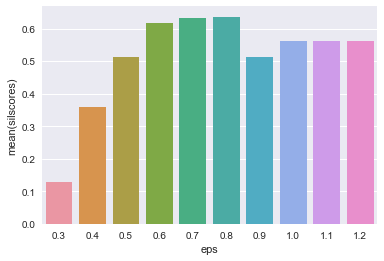

In [26]:
for eps in eps_grid:
    #Train DBSCAN Clustering model
    model=DBSCAN(eps=eps,min_samples=5).fit(data)
    labs=model.labels_
    #Performance metric
    sil_score=round(metrics.silhouette_score(data,labs),4)
    silhouette_scores.append(sil_score)
    models.append(model)
    labels.append(labs)

sweep = pd.DataFrame({'eps':eps_grid,'silscores':silhouette_scores})
sns.barplot(x='eps',y='silscores',data=sweep)

Now let's extract the best model/labels based on highest score of silhoueette score for given epsilons.

In [27]:
idxmax = sweep['silscores'].idxmax()
model_best = models[idxmax]; labels_best= labels[idxmax]
eps_best = eps_grid[idxmax]
print('Epsilon best is:',eps_best)

Epsilon best is: 0.8


Extract the number of clusters. Some datapoints may be unassigned, need to idenitfy them as follows:

In [28]:
offset = 0
if -1 in labels_best:
    offset = 1
num_clusters = len( np.unique(labels_best))-offset
print('Estimated number of clusters = ',num_clusters)

Estimated number of clusters =  5


Now we will visualize the results of the clustering, and assign outliers in the data set as black colors.

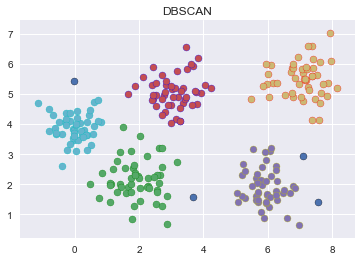

In [29]:
colors=['k','g','b','y','r','c']
labels = np.unique( labels_best)
plt.figure()
for col,lab in zip(colors,labels):
    clusterpoints = data.loc[(labels_best==lab)]
    plt.scatter(clusterpoints.x1,clusterpoints.x2,marker='o',
                   edgecolors=col)
    plt.title('DBSCAN')

We can see the clusters identified along with the outlier points above that are black (dark blueish). 

## 4.7 Finding patterns in stock market data<a class="anchor" id="stock"></a>

For this example we will use unsupervised learning for stock market analysis with the assumption that we do not know how many clusters there are, will try to use an algorithm called **Affinity Propagation** to cluster. It tries to find measures of similarity between pairs of datapoints and considers all the datapoints as potential representatives, also called **exemplars** of their respective clusters.

We will analyze the stock market variations of companies in a specified duration of time to find out which companies behave similarity in terms of quotes over time. 

Included in the files is *symbol_map.json* which maps abbreviations (stock ticker) to company name.

In [30]:
from matplotlib.finance import quotes_historical_yahoo_ochl as quotes_yahoo

import json
json_str = open('symbol_map.json').read()
symboldict = json.loads(json_str)
fullnames = np.array( list(symboldict.values()) )
symbols   = np.array( list(symboldict.keys()))
out = [print(key,'--->',symboldict[key]) for key in symboldict.keys()]

TOT ---> Total
XOM ---> Exxon
CVX ---> Chevron
COP ---> ConocoPhillips
VLO ---> Valero Energy
MSFT ---> Microsoft
IBM ---> IBM
TWX ---> Time Warner
CMCSA ---> Comcast
CVC ---> Cablevision
YHOO ---> Yahoo
DELL ---> Dell
HPQ ---> HP
AMZN ---> Amazon
TM ---> Toyota
CAJ ---> Canon
MTU ---> Mitsubishi
SNE ---> Sony
F ---> Ford
HMC ---> Honda
NAV ---> Navistar
NOC ---> Northrop Grumman
BA ---> Boeing
KO ---> Coca Cola
MMM ---> 3M
MCD ---> Mc Donalds
PEP ---> Pepsi
MDLZ ---> Kraft Foods
K ---> Kellogg
UN ---> Unilever
MAR ---> Marriott
PG ---> Procter Gamble
CL ---> Colgate-Palmolive
GE ---> General Electrics
WFC ---> Wells Fargo
JPM ---> JPMorgan Chase
AIG ---> AIG
AXP ---> American express
BAC ---> Bank of America
GS ---> Goldman Sachs
AAPL ---> Apple
SAP ---> SAP
CSCO ---> Cisco
TXN ---> Texas instruments
XRX ---> Xerox
LMT ---> Lookheed Martin
WMT ---> Wal-Mart
WBA ---> Walgreen
HD ---> Home Depot
GSK ---> GlaxoSmithKline
PFE ---> Pfizer
SNY ---> Sanofi-Aventis
NVS ---> Novartis
KMB ---> 

Let's choose start and end dates for the analysis:

In [31]:
import datetime
start_date = datetime.datetime(2004,4,5)
end_date   = datetime.datetime(2007,6,2)

Read the input data for each symbol, and create dataframe for the following quotes we want to look at: **open** and **close**

In [32]:
quotes        = [quotes_yahoo(symbol,start_date,end_date,asobject=True) for symbol in symboldict.keys()]
# Make index for dataframe from datetimes
datetimeindex = pd.DatetimeIndex(quotes[0]['date'])
openquotes = np.array([q['open'] for q in quotes]).T #date is row and columns are companies
closequotes= np.array([q['close'] for q in quotes]).T
openDF = pd.DataFrame(openquotes,columns=symbols,index=datetimeindex)
display(openDF.head())
closeDF = pd.DataFrame(closequotes,columns=symbols,index=datetimeindex)
closeDF.head()

,TOT,XOM,CVX,COP,VLO,MSFT,IBM,TWX,CMCSA,CVC,...,PFE,SNY,NVS,KMB,R,GD,RTN,CVS,CAT,DD
2004-04-05,23.105432,30.369554,28.155364,17.004470,10.159336,17.573491,72.957509,33.034877,8.257305,7.257713,...,21.622477,20.669434,27.986867,38.414240,30.261287,34.377722,22.712372,15.442025,28.848348,26.675008
2004-04-06,23.567193,30.434678,28.446019,17.264554,10.385903,17.546256,72.685714,33.303925,8.356655,7.179607,...,21.400985,20.581560,28.474237,38.535233,30.452813,34.955117,22.741159,16.154735,29.204501,26.851985
2004-04-07,23.405826,30.405733,28.481154,17.264554,10.272619,17.525830,72.507109,33.284704,8.416264,7.132744,...,21.412957,20.656880,28.774665,38.837704,30.491117,35.416558,22.949859,15.873970,29.425316,26.858088
2004-04-08,23.507612,30.557690,28.746259,17.524636,10.429054,17.580300,72.996338,33.592184,8.399233,7.123371,...,21.544657,20.499961,29.108477,39.109932,30.629018,35.714015,22.870699,15.895566,29.453807,26.827574
2004-04-12,23.482784,30.897782,28.762230,17.710410,10.438048,17.348801,72.608060,33.419222,8.447488,7.123371,...,21.311189,20.619219,28.974956,39.327714,30.337896,35.256386,22.942663,15.748705,29.275730,26.626186


,TOT,XOM,CVX,COP,VLO,MSFT,IBM,TWX,CMCSA,CVC,...,PFE,SNY,NVS,KMB,R,GD,RTN,CVS,CAT,DD
2004-04-05,23.301557,30.572162,28.446019,17.210060,10.330162,17.668815,73.136119,33.284703,8.450326,7.179607,...,21.628464,20.744755,28.474236,38.680417,30.468136,34.955115,22.877895,16.133136,29.350524,26.839780
2004-04-06,23.403342,30.528745,28.442827,17.257123,10.245646,17.566682,72.763369,33.438446,8.461680,7.129619,...,21.430916,20.462299,28.607759,38.976844,30.521763,35.530963,23.000235,16.042428,29.528601,26.949629
2004-04-07,23.311488,30.318902,28.666408,17.338863,10.285208,17.423698,72.281907,33.073313,8.316915,7.045260,...,21.353093,20.343041,28.961602,38.976844,30.222981,35.466133,22.834715,15.912845,29.240115,26.607878
2004-04-08,23.480304,30.716883,28.727095,17.616285,10.393095,17.348801,72.312970,33.419223,8.299884,7.060886,...,21.311189,20.493685,28.914868,38.595724,30.460473,35.248760,22.942663,15.748705,29.197379,26.504131
2004-04-12,23.731043,31.194459,29.215781,17.923430,10.833631,17.437316,72.794432,33.380794,8.612123,7.201477,...,21.353093,20.437194,28.714579,38.456584,30.460473,35.630116,22.949860,16.150414,29.827767,26.888602


We need some feature points for analysis, so we will use the difference between the opening and closing quotes every day to analyze the data:

In [33]:
deltaDF = closeDF - openDF
deltaDF.head()

,TOT,XOM,CVX,COP,VLO,MSFT,IBM,TWX,CMCSA,CVC,...,PFE,SNY,NVS,KMB,R,GD,RTN,CVS,CAT,DD
2004-04-05,0.196125,0.202608,0.290655,0.205590,0.170826,0.095324,0.178610,0.249826,0.193021,-0.078106,...,0.005987,0.075321,0.487369,0.266177,0.206849,0.577393,0.165523,0.691111,0.502176,0.164772
2004-04-06,-0.163851,0.094067,-0.003192,-0.007431,-0.140257,0.020426,0.077655,0.134521,0.105025,-0.049988,...,0.029931,-0.119261,0.133522,0.441611,0.068950,0.575846,0.259076,-0.112307,0.324100,0.097644
2004-04-07,-0.094338,-0.086831,0.185254,0.074309,0.012589,-0.102132,-0.225202,-0.211391,-0.099349,-0.087484,...,-0.059864,-0.313839,0.186937,0.139140,-0.268136,0.049575,-0.115144,0.038875,-0.185201,-0.250210
2004-04-08,-0.027308,0.159193,-0.019164,0.091649,-0.035959,-0.231499,-0.683368,-0.172961,-0.099349,-0.062485,...,-0.233468,-0.006276,-0.193609,-0.514208,-0.168545,-0.465255,0.071964,-0.146861,-0.256428,-0.323443
2004-04-12,0.248259,0.296677,0.453551,0.213020,0.395583,0.088515,0.186372,-0.038428,0.164635,0.078106,...,0.041904,-0.182025,-0.260377,-0.871130,0.122577,0.373730,0.007197,0.401709,0.552037,0.262416


### Plotting a few companies

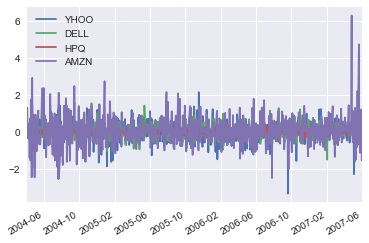

In [34]:
companies= ['YHOO', 'DELL', 'HPQ','AMZN']
deltaDF[companies].plot()

From the above it is apparent we should standardize the quotes from the companies since some have larger ranges than others:

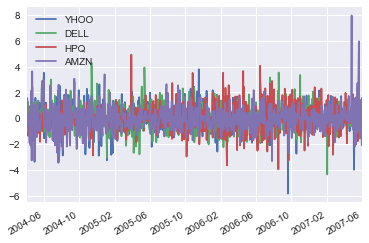

In [35]:
deltaDF = (deltaDF - deltaDF.mean()) / deltaDF.std()
deltaDF[companies].plot()

### Build a model

Many statistical problems require at some point the estimation of a population’s covariance matrix, which can be seen as an estimation of data set scatter plot shape. Most of the time, such an estimation has to be done on a sample whose properties (size, structure, homogeneity) has a large influence on the estimation’s quality. 

The matrix inverse of the covariance matrix, often called the precision matrix, is proportional to the partial correlation matrix. It gives the partial independence relationship. In other words, if two features are independent conditionally on the others, the corresponding coefficient in the precision matrix will be zero. This is why it makes sense to estimate a sparse precision matrix: by learning independence relations from the data, the estimation of the covariance matrix is better conditioned. This is known as covariance selection.

In the small-samples situation, in which *n_samples* is on the order of *n_features* or smaller, sparse inverse covariance estimators tend to work better than shrunk covariance estimators. However, in the opposite situation, or for very correlated data, they can be numerically unstable. In addition, unlike shrinkage estimators, sparse estimators are able to recover off-diagonal structure.

The GraphLasso estimator uses an **l1** penalty to enforce sparsity on the precision matrix: the higher its alpha parameter, the more sparse the precision matrix. The corresponding GraphLassoCV object uses cross-validation to automatically set the alpha parameter.

The inverse covariance is a measure of precision just as variance is a measure of dispersion. **Covariance** is a measure of how the variables are dispersed around the mean (the diagonal elements) and how they co-vary with other variables (the off-diagonal) elements. The more the dispersion the farther apart they are from the mean and the more they co-vary (in absolute value) with the other variables the stronger is the tendency for them to 'move together' (in the same or opposite direction depending on the sign of the covariance).

Similarly, **inverse covariance** is a measure of how tightly clustered the variables are around the mean (the diagonal elements) and the extent to which they do not co-vary with the other variables (the off-diagonal elements). Thus, the higher the diagonal element, the tighter the variable is clustered around the mean. 

In [36]:
from sklearn import covariance, cluster
edge_model = covariance.GraphLassoCV()

# Train model
with np.errstate(invalid='ignore'):
    edge_model.fit(deltaDF)

# Build clustering model using affinity propagation
_,labels = cluster.affinity_propagation(edge_model.covariance_)
num_labels = labels.max()

# Group all names from similar clusters together
for i in range(num_labels+1):
    print('Cluster ',i+1,"--->",','.join(fullnames[labels==i]))

Cluster  1 ---> Total,Exxon,Chevron,ConocoPhillips,Valero Energy
Cluster  2 ---> Cablevision
Cluster  3 ---> Yahoo,Amazon
Cluster  4 ---> Toyota,Canon,Mitsubishi,Sony,Honda,Boeing,Mc Donalds,Unilever,Apple,SAP,Wal-Mart,Pfizer,Caterpillar
Cluster  5 ---> Northrop Grumman,Lookheed Martin,General Dynamics,Raytheon
Cluster  6 ---> Coca Cola,Pepsi
Cluster  7 ---> Kraft Foods
Cluster  8 ---> Procter Gamble,Colgate-Palmolive,Kimberly-Clark
Cluster  9 ---> Time Warner,Comcast,Navistar,3M,Kellogg,Marriott,General Electrics,Wells Fargo,JPMorgan Chase,AIG,American express,Bank of America,Goldman Sachs,Xerox,Home Depot,Ryder,DuPont de Nemours
Cluster  10 ---> Microsoft,IBM,Dell,HP,Ford,Cisco,Texas instruments
Cluster  11 ---> Walgreen,CVS
Cluster  12 ---> GlaxoSmithKline,Sanofi-Aventis,Novartis


The above show clusters that one might expect, for example two pharamcies: Walgreen and CVS are in their own cluster and same with two soda companies: CocaCola and Pepsi. Let's zoom in on some dates for the clusters to show that they co-vary together:

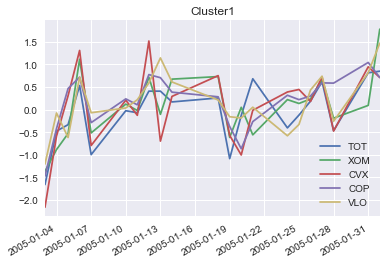

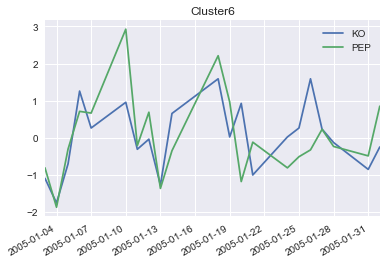

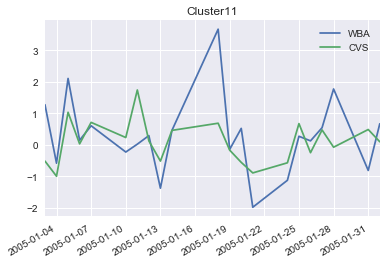

In [37]:
example = deltaDF['20050101':'20050201']
#Cluster 1
example[symbols[labels==0]].plot(title='Cluster1')
example[symbols[labels==5]].plot(title='Cluster6')
example[symbols[labels==10]].plot(title='Cluster11')

## 4.8 Building a customer segmentation model<a class="anchor" id="customer"></a>

One of the largest applications of unsupervised machine learning is market segmentation, when there is no labeled data available all the time, but it's important to segment the market so that people can target individual groups. Usefull in advertising, inventory management, distriubtion, mass media, etc.

The example used here is a data set referring to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories, the data available at https://archive.ics.uci.edu/ml/datasets/Wholesale+customers. The spreadsheet contains data regarding the consumption of different types of items by their customers and our goal is to find clusters so that they can optimize their sales and distribution strategy.

Below is information on the data, availabe in *wholesale.csv*:

1.	FRESH: annual spending (m.u.) on fresh products (Continuous) 
2.	MILK: annual spending (m.u.) on milk products (Continuous) 
3.	GROCERY: annual spending (m.u.)on grocery products (Continuous); 
4.	FROZEN: annual spending (m.u.)on frozen products (Continuous) 
5.	DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
6.	DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous); 
7.	CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal) 
8.	REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal) 

Descriptive Statistics: 

(Minimum, Maximum, Mean, Std. Deviation):
- FRESH (	3, 112151, 12000.30, 12647.329) 
- MILK	(55, 73498, 5796.27, 7380.377) 
- GROCERY	(3, 92780, 7951.28, 9503.163) 
- FROZEN	(25, 60869, 3071.93, 4854.673) 
- DETERGENTS_PAPER (3, 40827, 2881.49, 4767.854) 
- DELICATESSEN (3, 47943, 1524.87, 2820.106) 

  REGION	Frequency 
- Lisbon	77 
- Oporto	47 
- Other Region	316 
- Total	440 

  CHANNEL	Frequency 
- Horeca	298 
- Retail	142 
- Total	440 

Load the data:

In [38]:
from sklearn import cluster, covariance, manifold
from sklearn.cluster import MeanShift, estimate_bandwidth

data = pd.read_csv('wholesale.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Channel above refers to:
1. Horeca (hotel,restaurant or cafe)
2. Retail 

Region refers to:
1. Lisbon
2. Oporto
3. Other

### Make a few plots

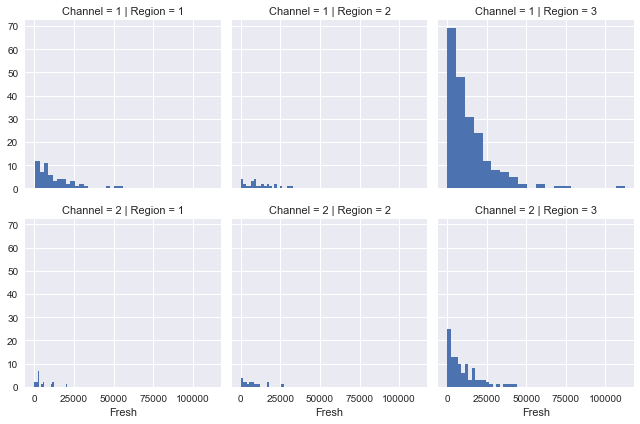

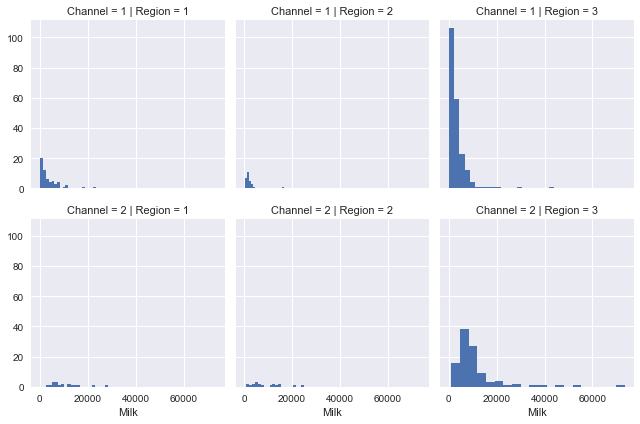

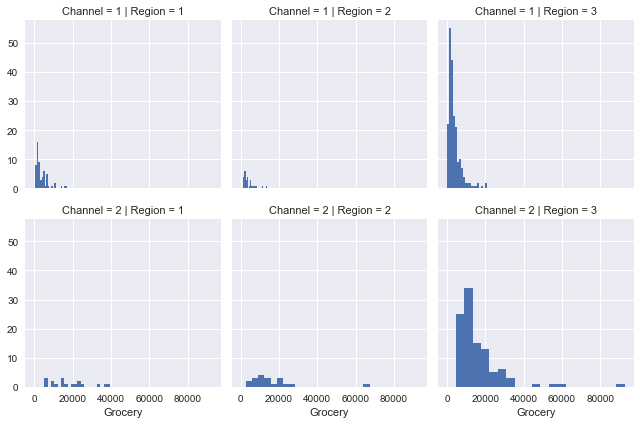

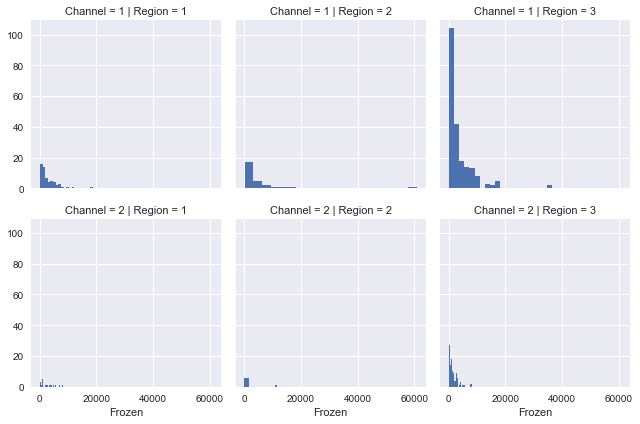

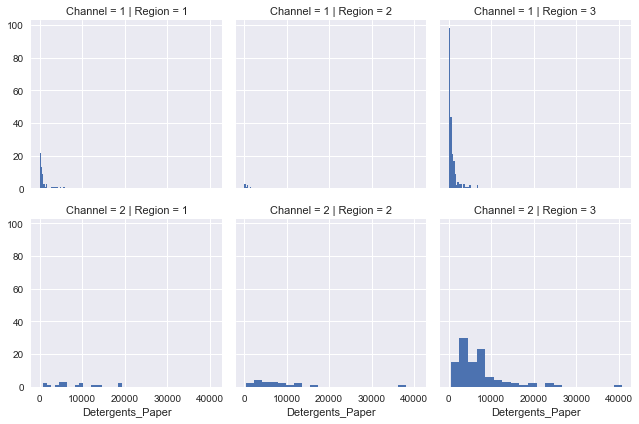

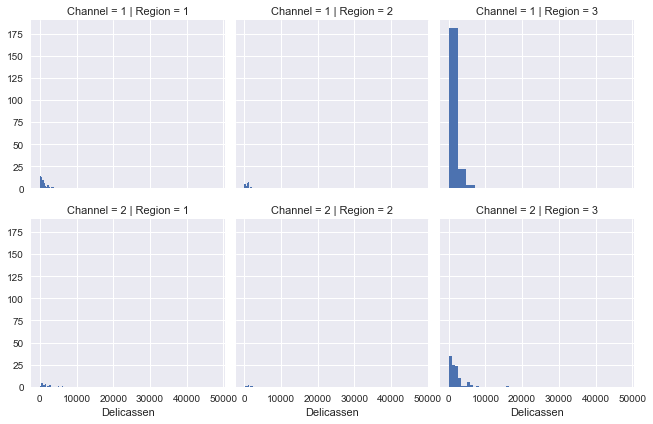

In [39]:
features = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']
for feature in features:
    plt.figure()
    g = sns.FacetGrid(data=data,col='Region',row='Channel')
    g.map(plt.hist,feature,bins=20)

### Build a Mean Shift Model

We're going to drop the region and channel to see what the clustering finds without those features.

In [40]:
X = data.drop(['Channel','Region'],axis=1)
#Estimate bandwidth
bandwidth = estimate_bandwidth(X.values,quantile=0.8,n_samples=len(data.index))

#Compute clustering with MeanShift
meanshift_estimator = MeanShift(bandwidth=bandwidth,bin_seeding=True)
meanshift_estimator.fit(X)
labels     = meanshift_estimator.labels_
centroids  = meanshift_estimator.cluster_centers_
n_clusters = len(np.unique(labels))

print('Number of clusters retrieved from Mean Shift Model = ',n_clusters)

Number of clusters retrieved from Mean Shift Model =  8


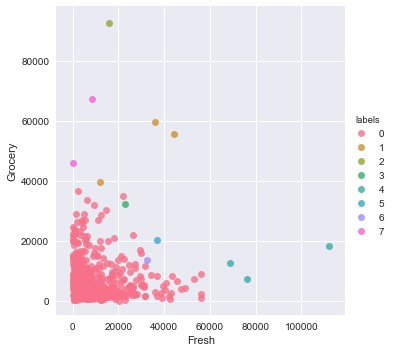

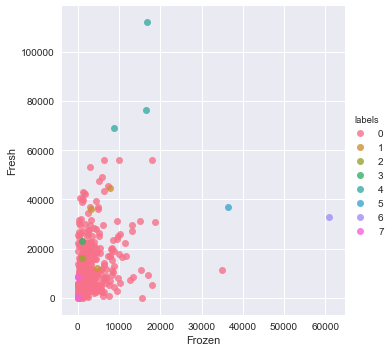

In [41]:
X['labels'] = labels
sns.lmplot(data=X,x='Fresh',y='Grocery',hue='labels',fit_reg=False)
sns.lmplot(data=X,x='Frozen',y='Fresh',hue='labels',fit_reg=False)

In [42]:
# Print the corresponding centroids of the clusters
print('Centroids of clusters:')
print('\t'.join(features))
for centroid in centroids:
    print('\t'.join([str(int(x)) for x in centroid]))

Centroids of clusters:
Fresh	Milk	Grocery	Frozen	Detergents_Paper	Delicassen
9632	4671	6593	2570	2296	1248
40204	46314	57584	5518	25436	4241
16117	46197	92780	1026	40827	2944
22925	73498	32114	987	20070	903
112151	29627	18148	16745	4948	8550
36847	43950	20170	36534	239	47943
32717	16784	13626	60869	1272	5609
8565	4980	67298	131	38102	1215


Plot corresponding centroid of clusters for milk/groceries/fresh:

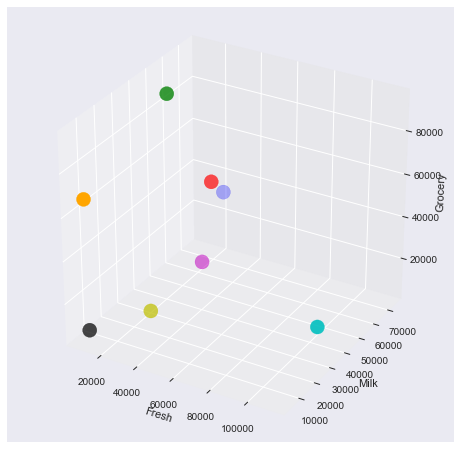

In [43]:
from mpl_toolkits.mplot3d import Axes3D
colors=['k','r','g','b','c','m','y','orange']
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], zdir='z', s=200, c=colors)
ax.set_xlabel('Fresh');ax.set_ylabel('Milk');ax.set_zlabel('Grocery')

In [44]:
#Silhouette Score
score = metrics.silhouette_score(X,labels,metric='euclidean', sample_size=len(X.index))
print('Silhouette score: ',score)

Silhouette score:  0.654825306202
